NOTEBOOOK DE CRAETION DES ORIGINE DESTINATION LAPI

In [3]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os, math
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IMPORT DONNEES GLOBALES (SUPPRESSION DES DOUBLONS EN MM TEMPS)

In [4]:
%%time 
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')
#df_3semaines=df_3semaines.drop_duplicates(['created','immat'])
df_3semaines=df_3semaines.set_index('created').sort_index()

Wall time: 1min 45s


VERIFICATION DES DONNEES

In [ ]:
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons.loc[doublons.duplicated(['created','immat'],keep=False)]

In [27]:
%%time 
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]

#!!!!!!! ATTENTION : PAS DE TRAITEMENTS EFFECTUES POUR CES ERREURS POUR LE MOMENT !
#propositions : supprimer 1 des 2 occurences pour les docblons
#supprmer les plques mal lues.


In [27]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

LISTE DES TRAJETS

In [5]:
liste_complete_trajet=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [6]:
liste_complete_trajet

cam_d  cam_o             cameras destination     long_km  nb_cams  \
0      11     15  (15, 19, 4, 5, 11)         A10  120.325213        5   
1      11     15  (15, 19, 1, 5, 11)         A10  125.202188        5   
13     13     12  (12, 6, 3, 18, 13)         A63  105.139253        5   
12     13     12  (12, 6, 2, 18, 13)         A63  108.707013        5   
56      7     15      (15, 19, 4, 7)         A89   90.709158        4   
36     11     10      (10, 4, 5, 11)         A10   64.969553        4   
31     13      6      (6, 3, 18, 13)         A63   85.355597        4   
25      5     15      (15, 19, 1, 5)         N10   89.925738        4   
24      5     15      (15, 19, 4, 5)         N10   85.048763        4   
30     13      6      (6, 2, 18, 13)         A63   88.923357        4   
3      11     15      (15, 1, 5, 11)         A10  125.202188        4   
76     18     19      (19, 4, 5, 11)         A10   76.488556        4   
4      11     15     (15, 19, 5, 11)         A10  120.325213        4   
52     13      8      (8, 3, 18, 13)         A63   91.128643        4   
2      11     15      (15, 4, 5, 11)         A10  120.325213        4   
5      11     15     (15, 19, 4, 11)         A10  120.325213        4   
6      11     15     (15, 19, 1, 11)         A10  125.202188        4   
71     18     12      (12, 6, 3, 18)        A660   61.286893        4   
77     18     19      (19, 1, 5, 11)         A10   81.365531        4   
17     13     12     (12, 2, 18, 13)         A63  108.707013        4   
70     18     12      (12, 6, 2, 18)        A660   64.854653        4   
18     13     12     (12, 3, 18, 13)         A63  105.139253        4   
40      9     12       (12, 6, 3, 9)         A62   50.013745        4   
15     13     12      (12, 6, 3, 13)         A63  105.139253        4   
14     13     12      (12, 6, 2, 13)         A63  108.707013        4   
16     13     12     (12, 6, 18, 13)         A63  105.139253        4   
92      5     19          (19, 4, 5)         N10   41.212107        3   
41      9     12          (12, 3, 9)         A62   50.013745        3   
48      9     15         (15, 19, 9)         A62   73.187282        3   
54     13      8          (8, 3, 13)         A63   91.128643        3   
..    ...    ...                 ...         ...         ...      ...   
33     13      6          (6, 2, 13)         A63   88.923357        3   
44      5     10          (10, 4, 5)         N10   29.693103        3   
7      11     15         (15, 4, 11)         A10  120.325213        3   
8      11     15         (15, 1, 11)         A10  125.202188        3   
68      5      8              (8, 5)         N10   22.818129        2   
87     18      8             (8, 18)        A660   47.276283        2   
55     13      8             (8, 13)         A63   91.096571        2   
90     18      6             (6, 18)        A660   41.503238        2   
47      9      6              (6, 9)         A62   30.230090        2   
35     13      6             (6, 13)         A63   85.355597        2   
49      9     15             (15, 9)         A62   73.187282        2   
61      9      8              (8, 9)         A62   36.003136        2   
63      7     10             (10, 7)         A89   35.353498        2   
43      9     12             (12, 9)         A62   50.013745        2   
23     13     12            (12, 13)         A63  105.139253        2   
75     18     12            (12, 18)        A660   61.286893        2   
67      7     12             (12, 7)         A89   43.113096        2   
39     11     10            (10, 11)         A10   64.969553        2   
51     13     10            (10, 13)         A63   73.633687        2   
83     18     10            (10, 18)        A660   29.781327        2   
45      5     10             (10, 5)         N10   29.693103        2   
65     11      8             (8, 11)         A10   58.094579        2   
11     11     15            (15, 11)         A10  120.325213  

TESTS DONNEES COMPLETES

In [7]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-29 00:00:00',1,df_3semaines)

date : 2019-01-29 00:00:00 debut_traitement : 2019-04-29 15:01:19.303010
date : 2019-01-29 01:00:00 debut_traitement : 2019-04-29 15:01:20.288890
date : 2019-01-29 02:00:00 debut_traitement : 2019-04-29 15:01:20.978074
date : 2019-01-29 03:00:00 debut_traitement : 2019-04-29 15:01:22.659719
date : 2019-01-29 04:00:00 debut_traitement : 2019-04-29 15:01:23.788697
date : 2019-01-29 05:00:00 debut_traitement : 2019-04-29 15:01:25.086230
date : 2019-01-29 06:00:00 debut_traitement : 2019-04-29 15:01:26.859057
date : 2019-01-29 07:00:00 debut_traitement : 2019-04-29 15:01:30.752174
date : 2019-01-29 08:00:00 debut_traitement : 2019-04-29 15:01:35.168372
date : 2019-01-29 09:00:00 debut_traitement : 2019-04-29 15:01:41.157563
date : 2019-01-29 10:00:00 debut_traitement : 2019-04-29 15:01:44.751386
date : 2019-01-29 11:00:00 debut_traitement : 2019-04-29 15:01:48.293437
date : 2019-01-29 12:00:00 debut_traitement : 2019-04-29 15:01:51.706313
date : 2019-01-29 13:00:00 debut_traitement : 2019-

IMPORTANT : VERIF DES DOUBLONS ENTRE LES TRAJETS

In [830]:
df_depart=dico_od.loc[dico_od['destination']=='A89'].copy()
jointure=df_depart.merge(dico_od, on='immat')
jointure=jointure.loc[jointure.date_cam_1_x!=jointure.date_cam_1_y].copy()
(jointure.loc[((jointure.date_cam_1_y>=jointure.date_cam_1_x) & (jointure.date_cam_1_y<=jointure.date_cam_2_x)) |
              ((jointure.date_cam_2_y>=jointure.date_cam_1_x) & (jointure.date_cam_2_y<=jointure.date_cam_2_x))])

DATAFRAME DES TEMPS DE PARCOURS MAX AVEC LE TYPE

In [6]:
dico_tps_max.loc[(dico_tps_max['o_d']=='A63-N10')]

date           temps              type      o_d
0  2019-01-28 00:00:00        01:04:21           Cluster  A63-N10
0  2019-01-28 01:00:00        10:16:08  85eme_percentile  A63-N10
0  2019-01-28 02:00:00        01:03:59           Cluster  A63-N10
0  2019-01-28 03:00:00 01:33:18.599999  85eme_percentile  A63-N10
0  2019-01-28 04:00:00        01:11:06           Cluster  A63-N10
1  2019-01-28 05:00:00        01:17:35           Cluster  A63-N10
0  2019-01-28 06:00:00        01:38:54           Cluster  A63-N10
0  2019-01-28 06:15:00 02:04:59.799999  85eme_percentile  A63-N10
0  2019-01-28 06:30:00        01:28:32           Cluster  A63-N10
1  2019-01-28 06:45:00        01:19:53           Cluster  A63-N10
1  2019-01-28 07:00:00        01:09:04           Cluster  A63-N10
0  2019-01-28 07:15:00        01:08:25           Cluster  A63-N10
0  2019-01-28 07:30:00        01:19:50           Cluster  A63-N10
1  2019-01-28 07:45:00        01:13:27           Cluster  A63-N10
0  2019-01-28 08:00:00        01:19:06           Cluster  A63-N10
1  2019-01-28 08:15:00        01:17:38           Cluster  A63-N10
1  2019-01-28 08:30:00        01:16:52           Cluster  A63-N10
0  2019-01-28 08:45:00        01:04:35           Cluster  A63-N10
1  2019-01-28 09:00:00        01:17:48           Cluster  A63-N10
0  2019-01-28 10:00:00        01:20:15           Cluster  A63-N10
0  2019-01-28 11:00:00        01:12:08           Cluster  A63-N10
0  2019-01-28 12:00:00        01:12:48           Cluster  A63-N10
0  2019-01-28 13:00:00        01:12:27           Cluster  A63-N10
0  2019-01-28 14:00:00        01:13:26           Cluster  A63-N10
0  2019-01-28 14:15:00        01:22:54           Cluster  A63-N10
1  2019-01-28 14:30:00        01:30:13           Cluster  A63-N10
0  2019-01-28 14:45:00        01:27:59           Cluster  A63-N10
0  2019-01-28 15:00:00        01:18:56           Cluster  A63-N10
0  2019-01-28 15:15:00        01:11:22           Cluster  A63-N10
0  2019-01-28 15:30:00        01:19:23           Cluster  A63-N10
..                 ...             ...               ...      ...
0  2019-02-03 12:00:00        01:04:19           Cluster  A63-N10
0  2019-02-03 13:00:00        01:10:56           Cluster  A63-N10
0  2019-02-03 14:00:00        01:05:35           Cluster  A63-N10
1  2019-02-03 14:15:00 01:48:13.500000  85eme_percentile  A63-N10
1  2019-02-03 14:30:00 01:02:58.750000  85eme_percentile  A63-N10
0  2019-02-03 14:45:00 01:04:03.900000  85eme_percentile  A63-N10
0  2019-02-03 15:00:00        02:07:48  85eme_percentile  A63-N10
0  2019-02-03 15:15:00        02:15:45  85eme_percentile  A63-N10
0  2019-02-03 15:30:00 02:23:55.050000  85eme_percentile  A63-N10
0  2019-02-03 15:45:00 02:59:01.399999  85eme_percentile  A63-N10
1  2019-02-03 16:00:00 03:18:34.249999  85eme_percentile  A63-N10
1  2019-02-03 16:15:00 02:08:26.500000  85eme_percentile  A63-N10
1  2019-02-03 16:30:00 02:01:29.600000  85eme_percentile  A63-N10
0  2019-02-03 16:45:00        01:25:56  85eme_percentile  A63-N10
0  2019-02-03 17:00:00 02:28:05.299999  85eme_percentile  A63-N10
0  2019-02-03 17:15:00 01:31:37.500000  85eme_percentile  A63-N10
0  2019-02-03 17:30:00 08:33:59.199999  85eme_percentile  A63-N10
0  2019-02-03 17:45:00 01:52:31.500000  85eme_percentile  A63-N10
0  2019-02-03 18:00:00 01:55:41.050000  85eme_percentile  A63-N10
1  2019-02-03 18:15:00 01:48:12.800000  85eme_percentile  A63-N10
0  2019-02-03 18:30:00 02:08:17.200000  85eme_percentile  A63-N10
0  2019-02-03 18:45:00 01:29:07.750000  85eme_percentile  A63-N10
0  2019-02-03 19:00:00        01:05:05           Cluster  A63-N10
0  2019-02-03 19:15:00 01:44:56.600000  85eme_percentile  A63-N10
0  2019-02-03 19:30:00        01:07:57           Cluster  A63-N10
0  2019-02-03 19:45:00 01:12:22.400000  85eme_percentile  A63-N10
0  2019-02-03 20:00:00 05:48:33.949999  85eme_percentile  A63-N10
1  2019-02-03 21:00:00        01:08:26           Cluster  A63-N10
0  2019-02-03 22:00:00        01:10:13           Cluster  

CREER LE TABLEAU DE MATRICE O-D

In [9]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od,values='l', index='origine', columns='destination',aggfunc='count', margins=True )

destination     A10     A62     A63    A660    A89     N10    All
origine                                                          
A10             NaN   478.0   426.0   304.0   43.0     NaN   1251
A62           371.0     NaN    56.0   160.0  128.0   362.0   1077
A63           578.0    47.0     NaN     NaN  139.0  2962.0   3726
A660          277.0   118.0     NaN     NaN  151.0   650.0   1196
A89            58.0   162.0   249.0   217.0    NaN   190.0    876
N10             NaN   341.0  1453.0   448.0  101.0     NaN   2343
All          1284.0  1146.0  2184.0  1129.0  562.0  4164.0  10469

FILTRER LES DONNEES 

In [10]:
# df complete avec l'atribut filtre
df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dico_tps_max,liste_complete_trajet)

In [ ]:
#df uniquement des données filtrees
df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]

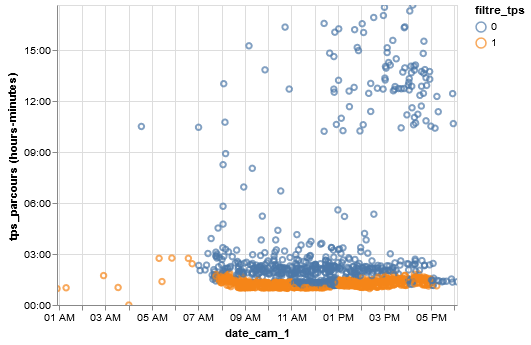

In [11]:
#exemple de visu
t.graph_transit_filtre(df_transit_avec_filtre, 'N10-A63')

POURCENTAGE PL PAR PLAGE HORAIRE ET CAMERA

In [432]:
#isoler pl source
groupe_tv_type_simple=df_journee.groupby('immat')['l'].apply(lambda x:test_unicite_type(list(x),mode='1/2')).reset_index().drop_duplicates('immat')
df_pl=df_journee.join(groupe_tv_type_simple.loc[groupe_tv_type_simple['l']==1].set_index('immat'),on='immat',how='inner',rsuffix='_right')
df_pl.set_index('created',inplace=True)

#obtenir les nb de pl par heure et par camera sur la source
df_synthese_pl_tot=df_pl.groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_tot'})
df_synthese_pl_transit=dico_passag.set_index('created').groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_transit'})
df_pct_pl_transit=pd.concat([df_synthese_pl_tot,df_synthese_pl_transit], axis=1, join='inner')
df_pct_pl_transit.columns=[['nb_pl_tot','nb_pl_transit']]
df_pct_pl_transit['pct_pl_transit']=df_pct_pl_transit.apply(lambda x : float(x['nb_pl_transit'])*100 / x['nb_pl_tot'] ,axis=1)
df_pct_pl_transit

In [ ]:
pct_pl=t.pourcentage_pl_camera('2019-01-28 00:00:00', 1,df_3semaines.reset_index(),dico_passag)
pct_pl

VERIFICATION

In [ ]:
# #retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='4c09dbea0bdad633c3ac4a88933f969996e242b2']

In [159]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0']

date_cam_1                                     immat state  l  \
18 2019-01-29 07:44:45  b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0    ES  1   

            date_cam_2      cameras origine destination      o_d tps_parcours  \
18 2019-01-29 09:10:44  (6, 18, 13)     N10         A63  N10-A63     01:25:59   

             period  
18 2019-01-29 07:30

In [137]:
#verif a un horaire donne sur un trajet direct ou indirect ou global
#%time trajet_test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19],modeRegroupement='aucun')
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 08:00:00', 60, [6, 13],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')

In [ ]:
liste1=test.df_transit.loc[(test.df_transit['o_d']=='A63-N10')].set_index(['immat','date_cam_1'])
liste2=dico_od.loc[dico_od['o_d']=='A63-N10'].set_index(['immat','date_cam_1'])
liste2.loc[~liste2.index.isin(liste1.index)]

In [278]:
test.df_transit.loc[test.df_transit['immat']=='4c09dbea0bdad633c3ac4a88933f969996e242b2']

Empty DataFrame
Columns: [date_cam_1, immat, state, l, date_cam_2, cameras, origine, destination, o_d, tps_parcours]
Index: []

In [15]:
#dfdes temps de parcours max autorise
test.df_transit

date_cam_1                                     immat  state  l  \
0    2019-01-29 08:00:44  294e464d2830064f2120d7965afee3cc2148e1cf     BE  1   
1    2019-01-29 08:00:47  033ddb143255f500956e63fc8cf67b847a2ba81b     BE  1   
2    2019-01-29 08:00:50  5b190bd1642a731fa3e2707e5f0495aca6e3b368     FR  1   
3    2019-01-29 08:01:45  82a41916834242edec4c2b214f5f7059284c34a8     ES  1   
4    2019-01-29 08:01:47  a9ec75696b598c850ea5dc8aff52b6532a027b24     FR  1   
5    2019-01-29 08:03:12  c97561e9b0651523e42164fd601f6f53e321fbad     IE  1   
6    2019-01-29 08:03:13  f97c4ab3d3c8f1a23efa0f31fec4e9b35bb9e9ee     BE  1   
7    2019-01-29 08:03:23  43bc0e5b1021a4c1adffaec28ab28f91dd60e546     PL  1   
8    2019-01-29 08:03:28  aa8bb6292ba09ee6d382798fd2106a3370c4d065     PT  1   
9    2019-01-29 08:03:31  ab59a6303f279eb7e24afeb456a53d234f004531         1   
10   2019-01-29 08:03:44  f5141b0926c120aa15d6e3f136e9d332600ca721     PL  1   
11   2019-01-29 08:03:54  f1bfa126828f13e2a989dd8fe8d77af5fb4cae0b     ES  1   
12   2019-01-29 08:04:00  24bf60c3ea5d0edfdfc9391ada3ba6e212342e3b     IT  1   
13   2019-01-29 08:04:18  af4133a46c22151747c2384ca61faeed1c7785c1     ES  1   
14   2019-01-29 08:04:30  09760635619439a91d4f07e2d8adf2082cddb382     FR  1   
15   2019-01-29 08:04:34  911eecdbfbc11759354ec86065738b815834fad5  IT/FR  1   
16   2019-01-29 08:04:41  15c0f0cdc2ff6cad908990948227f36dcf283384     TR  1   
17   2019-01-29 08:05:08  3429f8768c368ad05d269edea63fad04dd545c5d     ES  1   
18   2019-01-29 08:05:19  b8e14f28651df710030e67bb9546d5dd2c0e1485     ES  1   
19   2019-01-29 08:05:22  01e50eefd326e48372ce282bfdd644283136d682     ES  1   
20   2019-01-29 08:05:32  f75ffdeadbd91a5ee46d9f5081a60d52b96d1f25     IE  1   
21   2019-01-29 08:05:38  4102af1737a8d1368a44a6215effa5f5c755e0fe     FR  1   
22   2019-01-29 08:06:01  471932458e6b2a6a8cf7c9d4826ddbd5ddb8aff1     FR  1   
23   2019-01-29 08:06:36  cdcb5af340cf1a52b5f12591bbdc14c20cb29871     PL  1   
24   2019-01-29 08:06:51  ab45d4c7b24f29e23d3079d65bb120252bbd7a85     RO  1   
25   2019-01-29 08:07:03  835d644d88a17fc2ea051c58b6ab01b94c8d7feb     ES  1   
26   2019-01-29 08:08:24  46e8b0187efec2c74d30a13ac532f6ba993cd219     PT  1   
27   2019-01-29 08:08:28  60738d8f52c867a76f41c0530b06b618d22b3397         1   
28   2019-01-29 08:08:28  827a9c2d947d0eff07b66aad23ca5c23715fa7e4     FR  1   
29   2019-01-29 08:08:41  d942c4d9df30c26c82bb61f092af14d8a35699d5     PT  1   
...                  ...                                       ...    ... ..   
2700 2019-01-29 17:02:48  d67c254bf347cb48624a6fec53b97891209f0893     FR  1   
2701 2019-01-29 17:03:15  927b60b364065cf765d6002f9a8db13011e6391f     FR  1   
2702 2019-01-29 17:03:37  c898d448e18e9122401ac45154a894085f1b366c     ES  1   
2703 2019-01-29 17:03:40  8d42dc526452adb6e7d8f72a69cd4ec5359b88c9     PT  1   
2704 2019-01-29 17:03:47  f19983df65a484792aa40b113d52047520bb1805     ES  1   
2705 2019-01-29 17:03:49  1664c76fca39c959b9acc9eebd49ac549df666ee     ES  1   
2706 2019-01-29 17:04:36  785d4a6cff8d1cd695b740875ee3c43f8e98f03c     UK  1   
2707 2019-01-29 17:04:50  22c618958eaa25a409c0cc04891c149739ab6e19     BG  1   
2708 2019-01-29 17:05:23  9e68f8cbb66142e93d3c1f86c53f31b0b853777f         1   
2709 2019-01-29 17:05:27  f215272ec640777db7953eeb6442d08ad2f8b4cf         1   
2710 2019-01-29 17:05:52  6864b4597a060a61f3b8b9bc4d612e3bad25c1c2     ES  1   
2711 2019-01-29 17:06:19  d374f82221ad31c7722cfe1b6a0afe13a22ec153     FR  1   
2712 2019-01-29 17:06:26  2d056f4ce54ee9769abbcf4125eeec6aa6129ba6     FR  1   
2713 2019-01-29 17:06:41  bcb586ae1c08b2fe7015d6f7ba3d488f3a7dcd45     ES  1   
2714 2019-01-29 17:06:44  92816867237da0d99022f494422dad64813f5940     ES  1   
2715 2019-01-29 17:10:20  2911c75214edb0acddcea6c2e71bd676c70708ca     ES  1   
2716 2019-01-29 17:11:44  9916a64ac97fe235511bdf9b04a874a4886fbd2e     FR  1   
2717 2019-01-29 17:14:53  357f19fc29df6ec0e5c8dab5ad006a913491150d     ES  1   
2718 2019-01-2

In [ ]:
#graph des temps de parcours et temps max
test.graph()['A63-A89']

In [ ]:
dico_od.loc[dico_od['o_d']=='N10-A660']

TESTS A LA MANO

In [240]:
#pour trouver un trajet direct (sans disticntion de type ou autre)
test2=t.trouver_passages_consecutif(df_3semaines, '2019-01-29 00:00:00', '2019-01-29 23:59:59', 15, 19)
#test2=test2.set_index('created_y').sort_index()

In [286]:
%%time
#pour test des fonctions de trajets global

def filtrer_passage(liste, df_liste_trajet,cam) :
    """
    Récuperer les cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste[:len(liste_cams)]
    else : return liste

def recuperer_date_cam2(liste,liste_created,df_liste_trajet,cam):
    """
    Récuperer les horaires de passage des cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste_created[len(liste_cams)-1]
    else : return liste_created[-1]
    
def test_unicite_type(liste_l, mode='unique'):
    """test pour voir si un vehicule a ete toujours vu de la mme façon ou non
       en entre : liste de valeur de l (qui traduit si c'est u pl ou non) iisues d'une df
       en sortie : integer 0  ou 1 ou -1
       """ 
    if mode=='unique' : 
        if len(set(liste_l))==1 :
            return liste_l[0]
        else : 
            return -1
    elif mode=='1/2' :
        if any(liste_l)==1 : 
            return 1
        else : 
            return -1

camera1, camera2=15,5
df=df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'].copy()
df_duree=df.loc['2019-01-29 00:00:00':'2019-01-29 23:59:59']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==camera1]
df_duree_autres_cam=df.loc[(df.loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
groupe=(df_duree_autres_cam.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 'l': lambda x : test_unicite_type(list(x),'1/2'),
                                                                               'created':lambda x: tuple(x)}))
groupe_pl=groupe.loc[groupe['l']==1].copy()
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_complete_trajet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_complete_trajet,camera1),axis=1)
df_ts_trajets=(groupe_pl.reset_index().merge(liste_complete_trajet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','state','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]

df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state']].rename(columns={'l_y':'l'}))
df_passag_transit

In [294]:
groupe_pl.loc['4c09dbea0bdad633c3ac4a88933f969996e242b2']

camera_id                                                        (13, 15, 5)
l                                                                          1
created      (2019-01-29 00:17:00, 2019-01-29 05:10:00, 2019-01-29 06:08:44)
Name: 4c09dbea0bdad633c3ac4a88933f969996e242b2, dtype: object

nb clusters = 2


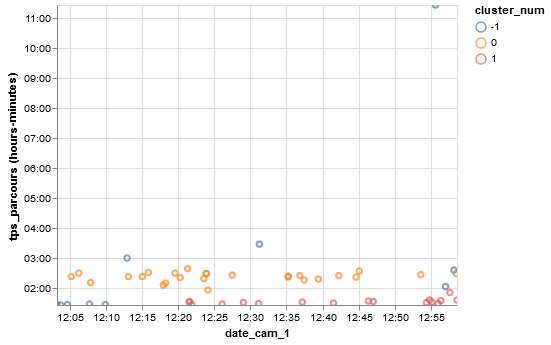

In [289]:
## pour tests des cluster
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 12:00:00', 60, [15, 11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
donnees=test.df_transit[test.df_transit['o_d']=='A63-A10'].copy()
donnees_src=donnees.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-29')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
#mise en forme des données pour passer dans sklearn 
matrice=np.array(liste_valeur).reshape(-1, 1)
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=1300, min_samples=len(liste_valeur)/4).fit(liste)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"nb clusters = {n_clusters_}")
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,donnees_src, left_on='index_base', right_index=True )
copie_df=results.copy()
copie_df.tps_parcours=pd.to_datetime('2018-01-29')+copie_df.tps_parcours
graph_tps_parcours = alt.Chart(copie_df).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)', color='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()
graph_tps_parcours

In [ ]:
results = pd.merge(results,donnees_src, left_on='index_base', right_index=True )

TESTS

In [122]:
a660_n10=dico_od.loc[dico_od['o_d']=='N10-A63'].copy()
a660_n10=a660_n10[a660_n10.apply(lambda x : x['date_cam_1'].to_period('D')==pd.Period('2019-01-29',freq='D'), axis=1)].reset_index().drop('index', axis=1)
a660_n10.tps_parcours=pd.to_datetime('2018-01-28')+a660_n10.tps_parcours

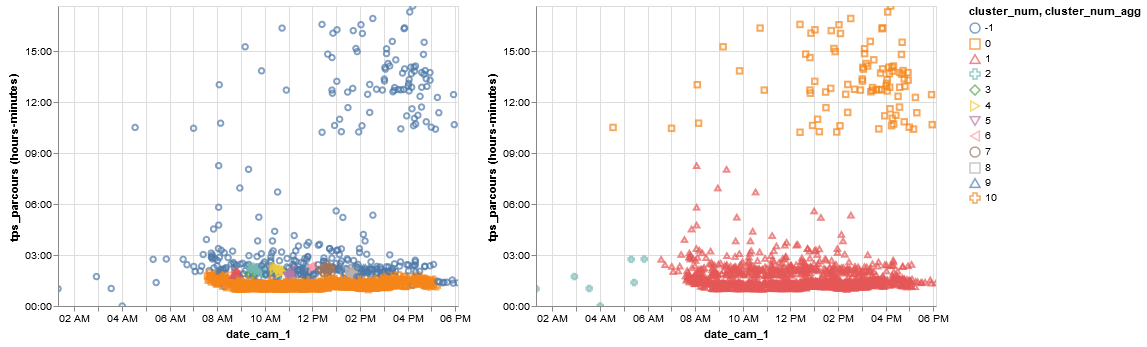

In [123]:
donnees_src=a660_n10.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
#temps_int=((pd.to_datetime('2018-01-28')+donnees_src['tps_parcours'])-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
liste_date=a660_n10.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
liste_valeur=a660_n10.tps_parcours.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
donnnes = temps_int.values
matrice=donnnes.reshape(-1, 1)
clustering=DBSCAN(eps=725, min_samples=10).fit(liste)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,a660_n10, left_on='index_base', right_index=True )

#results.tps_parcours=pd.to_datetime('2018-01-01')+results.tps_parcours
graph_tps_parcours1 = alt.Chart(results).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)',
                            color='cluster_num:N',
                            shape='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()

connectivity = kneighbors_graph(liste, n_neighbors=5, include_self=False)
ward = AgglomerativeClustering(n_clusters=3, 
                               linkage='average').fit(liste)
label_agg = ward.labels_
resultas = pd.DataFrame(pd.DataFrame([donnees_src.index,label_agg]).T)
resultas.columns = ['index_base', 'cluster_num_agg']
resultas = pd.merge(resultas,a660_n10, left_on='index_base', right_index=True )
#resultas.tps_parcours=pd.to_datetime('2018-01-01')+results.tps_parcours
graph_tps_parcours2 = alt.Chart(resultas).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)',
                            color='cluster_num_agg:N',
                            shape='cluster_num_agg:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()


graph_tps_parcours1 | graph_tps_parcours2

In [52]:
def filtre_tps_parcours(date_passage,tps_parcours, type_tps_lapi, tps_lapi, tps_theoriq, marge) : 
        """pour ajouter un attribut drapeau sur le tempsde parcours, et ne conserver que les trajets de transit"""
        
        if date_passage.hour in [20,21,22,23,0,1,2,3,4,5,6] : 
            marge += 480 #si le gars passe la nuit, on lui ajoute 8 heure de marge
        if type_tps_lapi=='Cluster':
            if tps_parcours < tps_lapi+pd.Timedelta(str(marge)+'min') :
                return 1
            else: 
                return 0
        else : 
            if tps_parcours < tps_theoriq+pd.Timedelta(str(marge)+'min') :
                return 1
            else: 
                return 0
def periode_carac(date_passage) :
    """
    pour calculer la période de passage selon une date
    """
    if date_passage.hour in [6,7,8,14,15,16,17,18,19] : 
        return date_passage.floor('15min').to_period('15min')
    else : 
        return date_passage.to_period('H')

In [132]:
dico_od_tps=dico_od.copy()
dico_tps_max_tps=dico_tps_max.copy()

In [133]:
dico_od_tps['period']=dico_od.apply(lambda x : periode_carac(x['date_cam_1']),axis=1)

In [134]:
dico_tps_max_tps['period']=dico_tps_max_tps.apply(lambda x : periode_carac(x['date']),axis=1)

In [135]:
df_transit_tps_parcours=dico_od_tps.merge(dico_tps_max_tps, on=['o_d','period'],how='left').merge(liste_complete_trajet[['cameras','tps_parcours_theoriq' ]], on='cameras')
df_transit_tps_parcours['filtre_tps']=df_transit_tps_parcours.apply(lambda x : filtre_tps_parcours(x['date_cam_1'],
                                                                x['tps_parcours'], x['type'], x['temps'], x['tps_parcours_theoriq'],10), axis=1)

In [127]:
dico_tps_max.loc[dico_tps_max['date']=='2019-01-29 16:45:00'].sort_values(['o_d']).head(30)

date           temps              type       o_d
0 2019-01-29 16:45:00 11:16:59.599999  85eme_percentile   A10-A62
2 2019-01-29 16:45:00 14:10:11.600000  85eme_percentile   A10-A63
1 2019-01-29 16:45:00 14:46:51.200000  85eme_percentile  A10-A660
4 2019-01-29 16:45:00        00:38:29  85eme_percentile   A62-A10
3 2019-01-29 16:45:00        13:58:03  85eme_percentile   A62-A63
2 2019-01-29 16:45:00 10:46:43.400000  85eme_percentile  A62-A660
0 2019-01-29 16:45:00        16:21:51  85eme_percentile   A62-A89
1 2019-01-29 16:45:00 00:13:46.900000  85eme_percentile   A62-N10
1 2019-01-29 16:45:00 12:47:42.900000  85eme_percentile   A63-A10
2 2019-01-29 16:45:00        01:07:52  85eme_percentile   A63-A62
0 2019-01-29 16:45:00        01:25:20           Cluster   A63-N10
2 2019-01-29 16:45:00        00:39:29  85eme_percentile  A660-A62
0 2019-01-29 16:45:00        17:25:33  85eme_percentile  A660-A89
1 2019-01-29 16:45:00 00:55:00.200000  85eme_percentile  A660-N10
1 2019-01-29 16:45:00 01:17:39.150000  85eme_percentile   A89-A63
0 2019-01-29 16:45:00        16:13:53  85eme_percentile  A89-A660
1 2019-01-29 16:45:00 00:33:43.500000  85eme_percentile   N10-A62
0 2019-01-29 16:45:00        01:15:52           Cluster   N10-A63
2 2019-01-29 16:45:00        00:42:23  85eme_percentile  N10-A660

In [115]:
dico_tps_max_tps.loc[dico_tps_max_tps['date']=='2019-01-29 16:45:00'].sort_values(['o_d']).head(30)

date           temps              type       o_d  \
0 2019-01-29 16:45:00 11:16:59.599999  85eme_percentile   A10-A62   
2 2019-01-29 16:45:00 14:10:11.600000  85eme_percentile   A10-A63   
1 2019-01-29 16:45:00 14:46:51.200000  85eme_percentile  A10-A660   
4 2019-01-29 16:45:00        00:38:29  85eme_percentile   A62-A10   
3 2019-01-29 16:45:00        13:58:03  85eme_percentile   A62-A63   
2 2019-01-29 16:45:00 10:46:43.400000  85eme_percentile  A62-A660   
0 2019-01-29 16:45:00        16:21:51  85eme_percentile   A62-A89   
1 2019-01-29 16:45:00 00:13:46.900000  85eme_percentile   A62-N10   
1 2019-01-29 16:45:00 12:47:42.900000  85eme_percentile   A63-A10   
2 2019-01-29 16:45:00        01:07:52  85eme_percentile   A63-A62   
0 2019-01-29 16:45:00        01:25:20           Cluster   A63-N10   
2 2019-01-29 16:45:00        00:39:29  85eme_percentile  A660-A62   
0 2019-01-29 16:45:00        17:25:33  85eme_percentile  A660-A89   
1 2019-01-29 16:45:00 00:55:00.200000  85eme_percentile  A660-N10   
1 2019-01-29 16:45:00 01:17:39.150000  85eme_percentile   A89-A63   
0 2019-01-29 16:45:00        16:13:53  85eme_percentile  A89-A660   
1 2019-01-29 16:45:00 00:34:19.950000  85eme_percentile   N10-A62   
0 2019-01-29 16:45:00        01:15:52           Cluster   N10-A63   
2 2019-01-29 16:45:00        00:42:23  85eme_percentile  N10-A660   

            period  
0 2019-01-29 16:45  
2 2019-01-29 16:45  
1 2019-01-29 16:45  
4 2019-01-29 16:45  
3 2019-01-29 16:45  
2 2019-01-29 16:45  
0 2019-01-29 16:45  
1 2019-01-29 16:45  
1 2019-01-29 16:45  
2 2019-01-29 16:45  
0 2019-01-29 16:45  
2 2019-01-29 16:45  
0 2019-01-29 16:45  
1 2019-01-29 16:45  
1 2019-01-29 16:45  
0 2019-01-29 16:45  
1 2019-01-29 16:45  
0 2019-01-29 16:45  
2 2019-01-29 16:45

In [136]:
len(dico_od_tps)

10469

In [137]:
len(df_transit_tps_parcours)

10469

In [138]:
pd.isnull(df_transit_tps_parcours).any(1).nonzero()[0]

array([], dtype=int64)

In [119]:
df_transit_tps_parcours.iloc[42]

date_cam_1                                   2019-01-29 14:34:17
immat                   67c43122cf380564b1e938fce6328ac5556b140b
state                                                         ES
l                                                              1
date_cam_2                                   2019-01-29 16:44:56
cameras                                          (15, 19, 5, 11)
origine                                                      A63
destination                                                  A10
o_d                                                      A63-A10
tps_parcours                                     0 days 02:10:39
period                                          2019-01-29 14:30
date                                                         NaT
temps                                                        NaT
type                                                         NaN
tps_parcours_theoriq                      0 days 01:30:14.634000
filtre_tps               

In [122]:
dico_tps_max.loc[(dico_tps_max['o_d']=='A63-A10')&(dico_tps_max['date']>'2019-01-29 14:00:00')].sort_values('date')

date           temps              type      o_d
1 2019-01-29 14:15:00 02:36:47.500000  85eme_percentile  A63-A10
0 2019-01-29 14:30:00        02:03:10  85eme_percentile  A63-A10
2 2019-01-29 14:45:00 01:54:12.500000  85eme_percentile  A63-A10
1 2019-01-29 15:00:00        03:02:55  85eme_percentile  A63-A10
1 2019-01-29 15:15:00 02:27:15.200000  85eme_percentile  A63-A10
1 2019-01-29 15:30:00 02:45:31.900000  85eme_percentile  A63-A10
2 2019-01-29 15:45:00 02:35:31.500000  85eme_percentile  A63-A10
1 2019-01-29 16:00:00 14:42:26.600000  85eme_percentile  A63-A10
1 2019-01-29 16:15:00 15:50:05.900000  85eme_percentile  A63-A10
1 2019-01-29 16:30:00 02:34:55.300000  85eme_percentile  A63-A10
1 2019-01-29 16:45:00 12:47:42.900000  85eme_percentile  A63-A10

In [48]:
rng = pd.date_range('1/1/2018 11:59:00', periods=3, freq='min')

In [49]:
rng

DatetimeIndex(['2018-01-01 11:59:00', '2018-01-01 12:00:00',
               '2018-01-01 12:01:00'],
              dtype='datetime64[ns]', freq='T')

In [51]:
rng.floor('15min')

DatetimeIndex(['2018-01-01 11:45:00', '2018-01-01 12:00:00',
               '2018-01-01 12:00:00'],
              dtype='datetime64[ns]', freq=None)

In [105]:
temps_parcours_max=dico_od.loc[(dico_od['o_d']=='A10-A63') & (dico_od['date_cam_1']>'2019-01-29 20:00:00') & 
                               (dico_od['date_cam_1']<'2019-01-29 20:15:00')]#.tps_parcours.quantile(0.85)

In [106]:
temps_parcours_max#.tps_parcours.quantile(0.85)

Empty DataFrame
Columns: [date_cam_1, immat, state, l, date_cam_2, cameras, origine, destination, o_d, tps_parcours]
Index: []

In [99]:
liste_date=[]
for date in pd.date_range('2019-01-29', periods=1*24, freq='H') : 
        if date.hour in [6,7,8,14,15,16,17,18,19] : 
            for date_15m in pd.date_range(date, periods=4, freq='15T') :
                liste_date.append([date_15m,15])
        else: 
            liste_date.append([date,60])

In [52]:
dico_od_graph=dico_od.copy()
dico_od_graph.tps_parcours=pd.to_datetime('2019-01-29')+dico_od_graph.tps_parcours

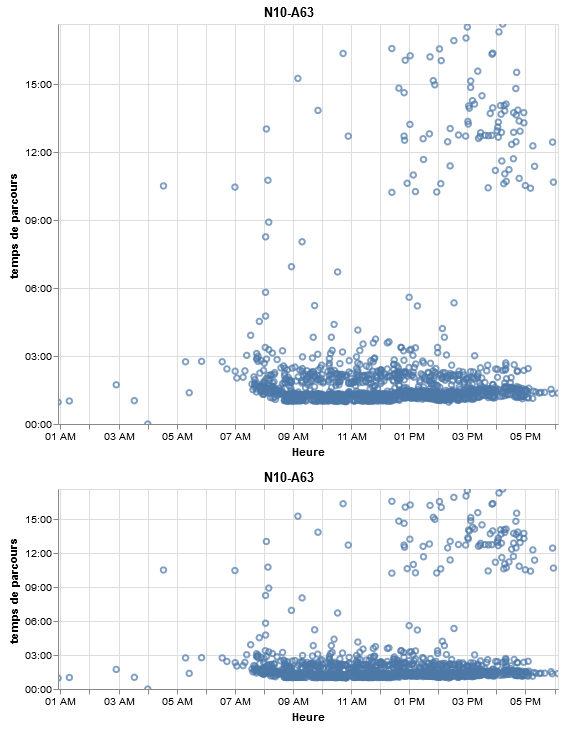

In [86]:
brush = alt.selection(type='interval', encodings=['y'])
up = alt.Chart(g_a63_n10,title='A10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',scale=alt.Scale(zero=False),title='Heure'),
                            y=alt.Y('hoursminutes(tps_parcours)',scale={'domain': brush.ref()},title='temps de parcours')).properties(width=500, height=200)
low=up.properties(
    height=400
).add_selection(brush)
alt.vconcat(low, up)

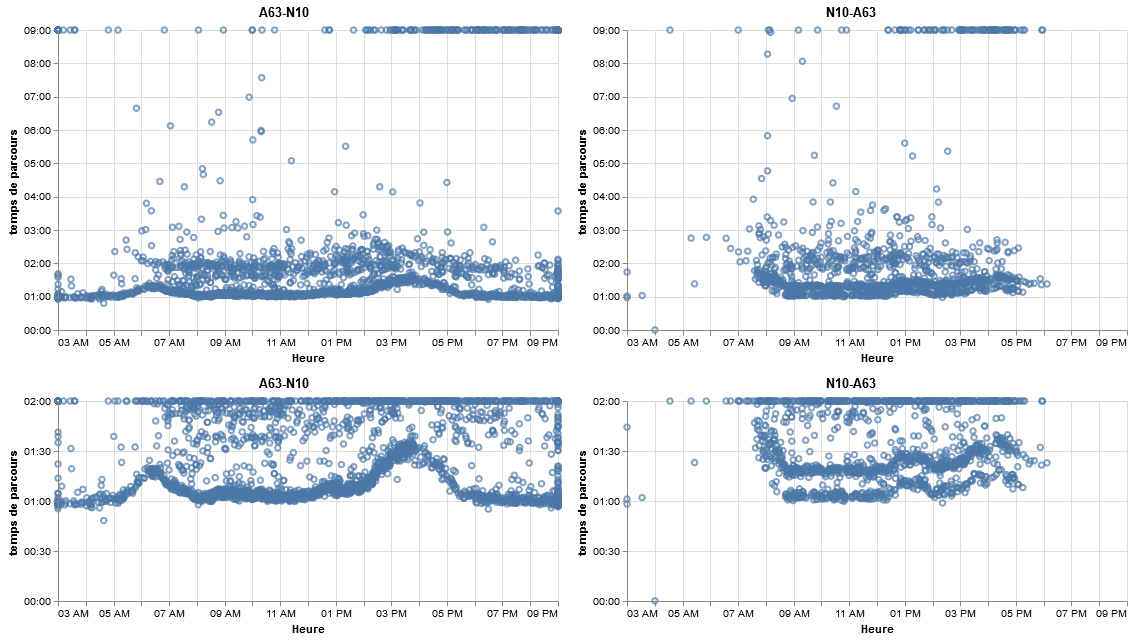

In [147]:
base_a63_n10 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='N10-A63'], title='N10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
a63_n10=alt.vconcat(up_a63_n10,low_a63_n10)

base_n10_a63 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A63-N10'], title='A63-N10').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
n10_a63=alt.vconcat(up_n10_a63,low_n10_a63)
n10_a63|a63_n10

DataTransformerRegistry.enable('default')

In [262]:
param_cluster=pd.DataFrame({'trajet':[('A10-A63','N10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A10-A63','N10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                       ],
              'temps_etudie':[15,60,15,60],
              'delai':[600,1200,800,1000],
              'nb_pt_min':[4,4,3,4]
             })
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [278]:
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 10:00:00', 60, [15,11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')

In [279]:
test.temps_parcours_max

date    temps              type      o_d
0 2019-01-29 10:00:00 01:22:38           Cluster  A63-N10
1 2019-01-29 10:00:00 02:49:06  85eme_percentile  A63-A10
2 2019-01-29 10:00:00 01:11:32           Cluster  A63-A89
3 2019-01-29 10:00:00 00:53:18           Cluster  A63-A62

In [160]:
param_cluster[(param_cluster.trajet.apply(lambda x : 'A10-A63' in x)) & (param_cluster['temps_etudie']==15)].delai.values[0]

600

In [263]:
param_cluster

delai  nb_pt_min  temps_etudie  \
0    600          4            15   
1   1200          4            60   
2    800          3            15   
3   1000          4            60   

                                                                                                                      trajet  
0  [A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
1  [A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
2  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]  
3  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]

In [255]:
liste_complete_trajet.loc[liste_complete_trajet['cameras']==(15, 19, 4, 5, 11)].o_d.values[0]

'A63-A10'